In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/titanic

/content/drive/MyDrive/Colab Notebooks/titanic


In [ ]:
train_data = pd.read_csv("input/train.csv")
test_data = pd.read_csv("input/test.csv")

**Analyse Data**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [ ]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [ ]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

**Pipelines for Data Transformation**

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

In [ ]:
class DataFrameSelector(BaseEstimator,TransformerMixin):
  def __init__(self,attribute_names):
    self.attribute_names = attribute_names
  def fit(self,X,y=None):
    return self
  def transform(self,X):
    return X[self.attribute_names]

In [ ]:
from sklearn.pipeline import Pipeline
try:
  from sklearn.impute import SimpleImputer
except ImportError:
  from sklearn.preprocessing import Imputer as SimpleImputer

In [ ]:
num_pipeline = Pipeline([
                         ("select_numeric",DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
                         ("imputer",SimpleImputer(strategy="median"))
])

In [ ]:
try:
  from sklearn.preprocessing import OrdinalEncoder
  from sklearn.preprocessing import OneHotEncoder
except ImportError:
  from future_encoders import OneHotEncoder

In [ ]:
class MostFrequentImputer(BaseEstimator,TransformerMixin):
  def fit(self,X,y=None):
    self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],index=X.columns)
    return self
  def transform(self,X,y=None):
    return X.fillna(self.most_frequent_)

In [ ]:
cat_pipeline = Pipeline([
                         ("select_cat",DataFrameSelector(["Pclass", "Sex", "Embarked"])),
                         ("imputer",MostFrequentImputer()),
                         ("cat_encoder",OneHotEncoder(sparse=False))
])

**Alternatively, We could remove DataFrame Selector and use Column Transformer instead of Feature Union**

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
full_pipeline = FeatureUnion(transformer_list=[
                                               ("num_pipeline",num_pipeline),
                                               ("cat_pipeline",cat_pipeline)
])

In [ ]:
X_train = full_pipeline.fit_transform(train_data)

In [ ]:
X_train

array([[22.,  1.,  0., ...,  0.,  0.,  1.],
       [38.,  1.,  0., ...,  1.,  0.,  0.],
       [26.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [28.,  1.,  2., ...,  0.,  0.,  1.],
       [26.,  0.,  0., ...,  1.,  0.,  0.],
       [32.,  0.,  0., ...,  0.,  1.,  0.]])

In [ ]:
y_train = train_data["Survived"]

In [ ]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
forest_scores = cross_val_score(random_forest,X_train,y_train,cv=10)
forest_scores.mean()

0.8126466916354558

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc_clf = SVC(gamma="auto")
svm_scores = cross_val_score(svc_clf,X_train,y_train,cv=10)
svm_scores.mean()

0.7329588014981274

In [ ]:
X_test = full_pipeline.fit_transform(test_data)

In [ ]:
import matplotlib.pyplot as plt

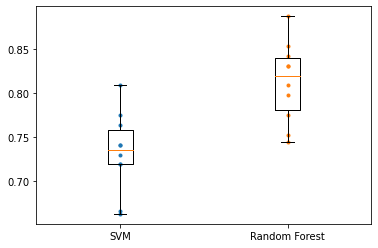

In [ ]:
plt.plot([1]*10,svm_scores,".")
plt.plot([2]*10,forest_scores,".")
plt.boxplot([svm_scores,forest_scores],labels=("SVM","Random Forest"))
plt.show()

In [ ]:
predictions = random_forest.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})

In [94]:
# output.to_csv("output.csv")